## 3. Numerics

Problem: -D * u''(x) + c * u'(x) = f(x)

Domain: x in [0,1]

Boundary Conditions: u(0) = u(1) = 0

Source function: f(x) = x (for analytical solution)

f(x) = x

In [1]:
from IPython.display import clear_output
clear_output()

In [2]:
### 3.0 Setup backend
from qiskit import QuantumCircuit, transpile
from qiskit.circuit import Parameter
from qiskit.providers.fake_provider import FakeGuadalupe
from qiskit import Aer
backend = Aer.get_backend('statevector_simulator')

C:\Users\CDAC\AppData\Local\Temp\ipykernel_20784\1824126142.py:6: DeprecationWarning: The 'qiskit.Aer' entry point is deprecated and will be removed in Qiskit 1.0. You should use 'qiskit_aer.Aer' directly instead.
  backend = Aer.get_backend('statevector_simulator')


In [3]:
### 3.1 Encode the problem Hamiltonian
import numpy as np
from scipy import sparse
from scipy.sparse import diags
import matplotlib.pyplot as plt
from qiskit.opflow import MatrixOp

plt.rcParams.update({"font.size": 16})

C:\Users\CDAC\AppData\Local\Temp\ipykernel_20784\2503753079.py:6: DeprecationWarning: The ``qiskit.opflow`` module is deprecated as of qiskit-terra 0.24.0. It will be removed in Qiskit 1.0. For code migration guidelines, visit https://qisk.it/opflow_migration.
  from qiskit.opflow import MatrixOp


In [4]:
N = 3   # number of qubits
dim = 2**N

D = 0.1   # diffusion coefficient
c = 1.0   # advection coefficient

# Grid
h = 1 / (dim - 1)
x_vals = np.linspace(0, 1, dim)

# f(x) = x
f_vec = x_vals
f_vec = f_vec * (h**2)  # scale for discretization

# Dirichlet BCs
f_vec[0] = 0
f_vec[-1] = 0
norm = np.linalg.norm(f_vec)
f_vec = f_vec / norm

# Second derivative (Laplace operator)
main_diag = -2 * np.ones(dim)
off_diag = np.ones(dim - 1)
L = diags([off_diag, main_diag, off_diag], [-1, 0, 1]).toarray()

# First derivative (central difference)
F = diags([-off_diag, off_diag], [-1, 1]).toarray() / 2

# Total operator A (not Hermitian)
A = -D * L / h**2 + c * F / h

# Make Hermitian operator: H = A†A
H = A.T @ A

# Solve classically
x_classical = np.linalg.solve(A, f_vec)
x_classical = x_classical / np.linalg.norm(x_classical)

# Eigenvector for benchmarking
eig_val, eig_vecs = np.linalg.eigh(H)
ground_state = eig_vecs[:, 0]  # eigenvector for smallest eigenvalue
ground_state = ground_state / np.linalg.norm(ground_state)

print("Classical solution:\n", x_classical)
print("Ground state of H (eigenvector):\n", ground_state)

# Convert to Pauli operators
H_op = MatrixOp(H).to_pauli_op()
print("Length of Pauli string:", len(H_op))
print(H_op)

Classical solution:
 [0.00588945 0.04122612 0.10598342 0.20000177 0.32232377 0.46720483
 0.60017761 0.51443795]
Ground state of H (eigenvector):
 [0.08448439 0.17734974 0.26526424 0.34317415 0.40757594 0.45461676
 0.47453809 0.41868234]
Length of Pauli string: 18
SummedOp([
  159.49500000000003 * III,
  -96.04000000000002 * IIX,
  8.575000000000003 * IIZ,
  11.760000000000003 * IXI,
  -48.02000000000001 * IXX,
  -48.02000000000001 * IYY,
  8.575000000000017 * IZI,
  -9.064999999999998 * IZZ,
  5.880000000000002 * XXI,
  -24.010000000000005 * XXX,
  24.010000000000005 * XYY,
  -24.010000000000005 * YXY,
  5.880000000000002 * YYI,
  -24.010000000000005 * YYX,
  8.575000000000001 * ZII,
  -9.065000000000003 * ZIZ,
  -9.065000000000003 * ZZI,
  8.575000000000001 * ZZZ
])


C:\Users\CDAC\AppData\Local\Temp\ipykernel_20784\3971405248.py:48: DeprecationWarning: The class ``qiskit.opflow.primitive_ops.matrix_op.MatrixOp`` is deprecated as of qiskit-terra 0.24.0. It will be removed in the Qiskit 1.0 release. For code migration guidelines, visit https://qisk.it/opflow_migration.
  H_op = MatrixOp(H).to_pauli_op()


In [5]:
### 3.2 Ansatz design
from qiskit.circuit.library import EfficientSU2

depth = 4
ansatz = EfficientSU2(N, entanglement='linear', reps=depth, skip_final_rotation_layer=True).decompose()
ansatz.draw(fold=300)

┌──────────┐┌──────────┐     ┌──────────┐┌──────────┐                  ┌───────────┐┌───────────┐                  ┌───────────┐┌───────────┐                       
q_0: ┤ Ry(θ[0]) ├┤ Rz(θ[3]) ├──■──┤ Ry(θ[6]) ├┤ Rz(θ[9]) ├───────────────■──┤ Ry(θ[12]) ├┤ Rz(θ[15]) ├───────────────■──┤ Ry(θ[18]) ├┤ Rz(θ[21]) ├───────────────■───────
     ├──────────┤├──────────┤┌─┴─┐└──────────┘├──────────┤┌───────────┐┌─┴─┐└───────────┘├───────────┤┌───────────┐┌─┴─┐└───────────┘├───────────┤┌───────────┐┌─┴─┐     
q_1: ┤ Ry(θ[1]) ├┤ Rz(θ[4]) ├┤ X ├─────■──────┤ Ry(θ[7]) ├┤ Rz(θ[10]) ├┤ X ├──────■──────┤ Ry(θ[13]) ├┤ Rz(θ[16]) ├┤ X ├──────■──────┤ Ry(θ[19]) ├┤ Rz(θ[22]) ├┤ X ├──■──
     ├──────────┤├──────────┤└───┘   ┌─┴─┐    ├──────────┤├───────────┤└───┘    ┌─┴─┐    ├───────────┤├───────────┤└───┘    ┌─┴─┐    ├───────────┤├───────────┤└───┘┌─┴─┐
q_2: ┤ Ry(θ[2]) ├┤ Rz(θ[5]) ├────────┤ X ├────┤ Ry(θ[8]) ├┤ Rz(θ[11]) ├─────────┤ X ├────┤ Ry(θ[14]) ├┤ Rz(θ[17]) ├─────────┤ X ├────┤ Ry(θ[20]) ├┤ Rz(θ[23]) ├─────┤ X ├
     └──────────┘└──────────┘        └───┘    └──────────┘└───────────┘         └───┘    └───────────┘└───────────┘         └───┘    └───────────┘└───────────┘     └───┘

In [6]:
### 3.3 Transpile
ansatz_opt = transpile(ansatz, backend=backend, optimization_level=3)
print('Number and type of gates in the circuit:', ansatz_opt.count_ops())
print('Number of parameters in the circuit:', ansatz_opt.num_parameters)
ansatz_opt.draw(fold=300)

Number and type of gates in the circuit: OrderedDict([('ry', 12), ('rz', 12), ('cx', 8)])
Number of parameters in the circuit: 24


┌──────────┐┌──────────┐     ┌──────────┐┌──────────┐                  ┌───────────┐┌───────────┐                  ┌───────────┐┌───────────┐                       
q_0: ┤ Ry(θ[0]) ├┤ Rz(θ[3]) ├──■──┤ Ry(θ[6]) ├┤ Rz(θ[9]) ├───────────────■──┤ Ry(θ[12]) ├┤ Rz(θ[15]) ├───────────────■──┤ Ry(θ[18]) ├┤ Rz(θ[21]) ├───────────────■───────
     ├──────────┤├──────────┤┌─┴─┐└──────────┘├──────────┤┌───────────┐┌─┴─┐└───────────┘├───────────┤┌───────────┐┌─┴─┐└───────────┘├───────────┤┌───────────┐┌─┴─┐     
q_1: ┤ Ry(θ[1]) ├┤ Rz(θ[4]) ├┤ X ├─────■──────┤ Ry(θ[7]) ├┤ Rz(θ[10]) ├┤ X ├──────■──────┤ Ry(θ[13]) ├┤ Rz(θ[16]) ├┤ X ├──────■──────┤ Ry(θ[19]) ├┤ Rz(θ[22]) ├┤ X ├──■──
     ├──────────┤├──────────┤└───┘   ┌─┴─┐    ├──────────┤├───────────┤└───┘    ┌─┴─┐    ├───────────┤├───────────┤└───┘    ┌─┴─┐    ├───────────┤├───────────┤└───┘┌─┴─┐
q_2: ┤ Ry(θ[2]) ├┤ Rz(θ[5]) ├────────┤ X ├────┤ Ry(θ[8]) ├┤ Rz(θ[11]) ├─────────┤ X ├────┤ Ry(θ[14]) ├┤ Rz(θ[17]) ├─────────┤ X ├────┤ Ry(θ[20]) ├┤ Rz(θ[23]) ├─────┤ X ├
     └──────────┘└──────────┘        └───┘    └──────────┘└───────────┘         └───┘    └───────────┘└───────────┘         └───┘    └───────────┘└───────────┘     └───┘

In [7]:
### 3.4 Optimizer
from qiskit.algorithms.optimizers import L_BFGS_B

optimizer = L_BFGS_B(maxiter=5000)

C:\Users\CDAC\AppData\Local\Temp\ipykernel_20784\3868400948.py:2: DeprecationWarning: ``qiskit.algorithms`` has been migrated to an independent package: https://github.com/qiskit-community/qiskit-algorithms. The ``qiskit.algorithms`` import path is deprecated as of qiskit-terra 0.25.0 and will be removed in Qiskit 1.0. Please run ``pip install qiskit_algorithms`` and use ``import qiskit_algorithms`` instead.
  from qiskit.algorithms.optimizers import L_BFGS_B


In [10]:
### 3.5 Define VQE program
from qiskit.utils import QuantumInstance
from qiskit.algorithms import VQE

quantum_instance = QuantumInstance(backend=backend, seed_simulator=42, seed_transpiler=42)

vqe = VQE(ansatz_opt, optimizer, quantum_instance=quantum_instance,
          initial_point=2*np.pi*np.random.rand(ansatz_opt.num_parameters))

result = vqe.compute_minimum_eigenvalue(H_op)
# quantum_solution = -1 * np.abs(result.eigenstate).real
quantum_solution = np.abs(result.eigenstate).real
quantum_solution = quantum_solution / np.linalg.norm(quantum_solution)

print("Quantum solution:\n", quantum_solution)
print("Minimum eigenvalue:", result.eigenvalue.real)

C:\Users\CDAC\AppData\Local\Temp\ipykernel_20784\2727458108.py:5: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed in the Qiskit 1.0 release. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend=backend, seed_simulator=42, seed_transpiler=42)
C:\Users\CDAC\AppData\Local\Temp\ipykernel_20784\2727458108.py:7: DeprecationWarning: The class ``qiskit.algorithms.minimum_eigen_solvers.vqe.VQE`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. Instead, use the class ``qiskit.algorithms.minimum_eigensolvers.VQE``. See https://qisk.it/algo_migration for a migration guide.
  vqe = VQE(ansatz_opt, optimizer, quantum_instance=quantum_instance,


Quantum solution:
 [0.08448444 0.17734983 0.26526435 0.34317421 0.40757592 0.45461669
 0.47453804 0.41868232]
Minimum eigenvalue: 1.91678543509521


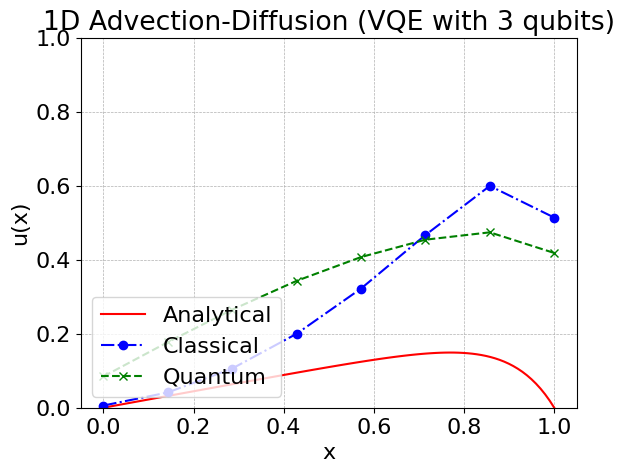

In [12]:
### 3.7 Benchmark with analytical solution
t = np.linspace(0, 1, 100)
D_val, c_val = D, c

# Analytical solution for f(x) = x
# Derived for u(0)=u(1)=0 and steady-state
# General form (assuming D ≠ 0):
# u(x) = (x - (1 - exp(c*x/D)) / (1 - exp(c/D))) - (x^3 - x)/6 scaled
from sympy import symbols, exp, simplify, lambdify
x = symbols('x')
exact_expr = (x - (1 - exp(c*x/D)) / (1 - exp(c/D)))
u_exact_fn = lambdify(x, exact_expr, modules='numpy')
res = u_exact_fn(t)
res = res - res[0]  # adjust for BCs
res = res / np.linalg.norm(res)

xt = np.linspace(0, 1, dim)
exact_discrete = u_exact_fn(xt)
exact_discrete = exact_discrete - exact_discrete[0]
exact_discrete = exact_discrete / np.linalg.norm(exact_discrete)

plt.plot(t, res, 'r-', label='Analytical')
plt.plot(x_vals, x_classical, 'bo-.', label='Classical')
plt.plot(x_vals, quantum_solution, 'gx--', label='Quantum')
plt.legend(loc='lower left')
plt.xlabel('x')
plt.ylabel('u(x)')
plt.ylim((0,1))
plt.title("1D Advection-Diffusion (VQE with {} qubits)".format(N))
plt.grid(linestyle='--', linewidth=0.5)
# plt.savefig("AdvectionDiffusion_VQE.png", dpi=300, bbox_inches='tight')
plt.show()

f(x) = sin(pi*x)

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import toeplitz

from qiskit import Aer
from qiskit.utils import QuantumInstance
from qiskit.opflow import PauliSumOp, MatrixOp
from qiskit.circuit.library import TwoLocal, EfficientSU2
from qiskit.algorithms import VQE
from qiskit.algorithms.optimizers import COBYLA, SPSA, L_BFGS_B

In [2]:
# PDE Parameters
D = 0.01
c = 1.0
n = 8
Lx = 1.0
h = Lx / (n + 1)
x = np.linspace(h, 1 - h, n)
# f_vec = np.sin(np.pi * x)
f_vec = x**2

In [3]:
# Discretized operators
L = toeplitz([2, -1] + [0]*(n-2)) + toeplitz([0, -1] + [0]*(n-2)).T
F = toeplitz([0, -1] + [0]*(n-2)) - toeplitz([1, 0] + [0]*(n-2)).T
A = -D * L / h**2 + c * F / (2*h)

# Reformulate into least-squares
H = A.T @ A
f_vec_new = A.T @ f_vec

# Classical solution
x_classical = np.linalg.solve(H, f_vec_new)
x_classical /= np.linalg.norm(x_classical)

In [4]:
# Analytical solution
def analytical_solution(x):
    Pe = c / D
    # Pe = 3
    num = np.exp(Pe * x) - 1
    denom = np.exp(Pe) - 1
    return num / denom * np.trapz(np.sin(np.pi * x) * np.exp(Pe * x), x)

x_full = np.linspace(0, 1, 100)
u_analytical = analytical_solution(x_full)

In [5]:
# # Quantum operator
# H_op = MatrixOp(H).to_pauli_op()
# f_term_op = -2 * MatrixOp(np.diag(f_vec_new)).to_pauli_op()
# cost_op = (H_op + f_term_op).reduce()

# # Convert to PauliSumOp (required by legacy VQE)
# pauli_op = PauliSumOp.from_operator(cost_op.to_matrix())
from qiskit.opflow import PauliTrotterEvolution

# Quantum operator
H_op = MatrixOp(H)
f_term_op = -2 * MatrixOp(np.diag(f_vec_new))
cost_op = (H_op + f_term_op).reduce()

# Convert MatrixOp to Pauli representation (Qiskit 0.39-compatible)
pauli_op = cost_op.to_pauli_op()

C:\Users\CDAC\AppData\Local\Temp\ipykernel_21244\3173637507.py:11: DeprecationWarning: The class ``qiskit.opflow.primitive_ops.matrix_op.MatrixOp`` is deprecated as of qiskit-terra 0.24.0. It will be removed in the Qiskit 1.0 release. For code migration guidelines, visit https://qisk.it/opflow_migration.
  H_op = MatrixOp(H)
C:\Users\CDAC\AppData\Local\Temp\ipykernel_21244\3173637507.py:12: DeprecationWarning: The class ``qiskit.opflow.primitive_ops.matrix_op.MatrixOp`` is deprecated as of qiskit-terra 0.24.0. It will be removed in the Qiskit 1.0 release. For code migration guidelines, visit https://qisk.it/opflow_migration.
  f_term_op = -2 * MatrixOp(np.diag(f_vec_new))


In [6]:
# Quantum instance
backend = Aer.get_backend('aer_simulator')
quantum_instance = QuantumInstance(backend=backend)

C:\Users\CDAC\AppData\Local\Temp\ipykernel_21244\540579176.py:2: DeprecationWarning: The 'qiskit.Aer' entry point is deprecated and will be removed in Qiskit 1.0. You should use 'qiskit_aer.Aer' directly instead.
  backend = Aer.get_backend('aer_simulator')
C:\Users\CDAC\AppData\Local\Temp\ipykernel_21244\540579176.py:3: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed in the Qiskit 1.0 release. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend=backend)


In [9]:
# VQE
# ansatz = TwoLocal(num_qubits=3, reps=2, rotation_blocks='ry', entanglement_blocks='cz')
# ansatz = TwoLocal(num_qubits=3, reps=2, rotation_blocks='ry', entanglement_blocks='cz', entanglement='circular')
depth = 5 # depth of ansatz
# ansatz = EfficientSU2(num_qubits=3, entanglement='linear', reps=depth, skip_final_rotation_layer=True)
ansatz = EfficientSU2(num_qubits=3, entanglement='circular', reps=depth, skip_final_rotation_layer=False)

# optimizer = COBYLA(maxiter=100)
optimizer = L_BFGS_B(maxiter=5000)
# optimizer = SPSA(maxiter=30000)
vqe = VQE(ansatz=ansatz, optimizer=optimizer, quantum_instance=quantum_instance)
result = vqe.compute_minimum_eigenvalue(operator=pauli_op)

C:\Users\CDAC\AppData\Local\Temp\ipykernel_21244\1787748008.py:11: DeprecationWarning: The class ``qiskit.algorithms.minimum_eigen_solvers.vqe.VQE`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. Instead, use the class ``qiskit.algorithms.minimum_eigensolvers.VQE``. See https://qisk.it/algo_migration for a migration guide.
  vqe = VQE(ansatz=ansatz, optimizer=optimizer, quantum_instance=quantum_instance)


In [10]:
from qiskit.quantum_info import Statevector

# 1. Extract optimal parameters
optimal_params = result.optimal_point

# 2. Bind them to your ansatz to get the optimal circuit
optimal_circuit = ansatz.bind_parameters(optimal_params)

# 3. Simulate the statevector from the bound circuit
statevector = Statevector.from_instruction(optimal_circuit)

# 4. Extract first `n` amplitudes as your solution
vec = statevector.data[:n]
vec_real = np.real(vec / np.linalg.norm(vec))  # Normalize

C:\Users\CDAC\AppData\Local\Temp\ipykernel_21244\4161867224.py:7: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.bind_parameters()`` is deprecated as of qiskit 0.45.0. It will be removed in the Qiskit 1.0.0 release. Use assign_parameters() instead
  optimal_circuit = ansatz.bind_parameters(optimal_params)


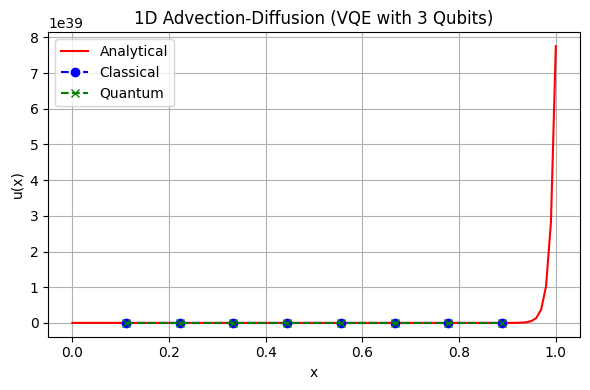

In [11]:
# Plot
plt.figure(figsize=(6, 4))
plt.plot(x_full, u_analytical, label='Analytical', color='red')
plt.plot(x, x_classical, 'bo--', label='Classical')
plt.plot(x, vec_real, 'gx--', label='Quantum')
plt.xlabel('x')
plt.ylabel('u(x)')
plt.title('1D Advection-Diffusion (VQE with 3 Qubits)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()